In [1]:
# Load Packages
!pip install yfinance
import numpy as np
import pandas as pd
#from pandas_datareader import data
import matplotlib.pyplot as plt
import yfinance as yf
%matplotlib inline


In [2]:
def TSMStrategy(returns, period=1, shorts=False):
    if shorts:
        position = returns.rolling(period).mean().map(
            lambda x: -1 if x <= 0 else 1)
    else:
        position = returns.rolling(period).mean().map(
            lambda x: 0 if x <= 0 else 1)
    performance = position.shift(1) * returns
    return performance

In [3]:
ticker='BEEF3.SA'
data = yf.download(['BEEF3.SA'],start='2010-01-01', end='2023-08-09')
data.head()


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,5.703109,5.742441,5.673611,5.722775,4.239651,130174
2010-01-05,5.781773,6.047263,5.771940,5.948933,4.407198,2505657
2010-01-06,6.037430,6.273420,6.037430,6.243922,4.625737,1832003
2010-01-07,6.194757,6.411082,6.096427,6.381583,4.727722,1553857
2010-01-08,6.420915,6.833898,6.420915,6.784734,5.026391,2404873


In [4]:
returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()
returns

Date
2010-01-05    0.038758
2010-01-06    0.048397
2010-01-07    0.021808
2010-01-08    0.061259
2010-01-11   -0.019020
                ...   
2023-08-02    0.001955
2023-08-03    0.028876
2023-08-04    0.015066
2023-08-07   -0.007505
2023-08-08   -0.000942
Name: Close, Length: 3375, dtype: float64

In [5]:
performance = TSMStrategy(returns, period=1, shorts=True).dropna()
years = (performance.index.max() - performance.index.min()).days / 365
perf_cum = np.exp(performance.cumsum())
tot = perf_cum[-1] - 1
ann = perf_cum[-1] ** (1 / years) - 1
vol = performance.std() * np.sqrt(252)
rfr = 0.10
sharpe = (ann - rfr) / vol
print(f"1-day TSM Strategy yields:" +
      f"\n\t{tot*100:.2f}% total returns" +
      f"\n\t{ann*100:.2f}% annual returns" +
      f"\n\t{sharpe:.2f} Sharpe Ratio")
gme_ret = np.exp(returns.cumsum())
b_tot = gme_ret[-1] - 1
b_ann = gme_ret[-1] ** (1 / years) - 1
b_vol = returns.std() * np.sqrt(252)
b_sharpe = (b_ann - rfr) / b_vol
print(f"Baseline Buy-and-Hold Strategy yields:" +
      f"\n\t{b_tot*100:.2f}% total returns" +
      f"\n\t{b_ann*100:.2f}% annual returns" +
      f"\n\t{b_sharpe:.2f} Sharpe Ratio")

1-day TSM Strategy yields:
	123.12% total returns
	6.08% annual returns
	-0.10 Sharpe Ratio
Baseline Buy-and-Hold Strategy yields:
	85.40% total returns
	4.65% annual returns
	-0.14 Sharpe Ratio


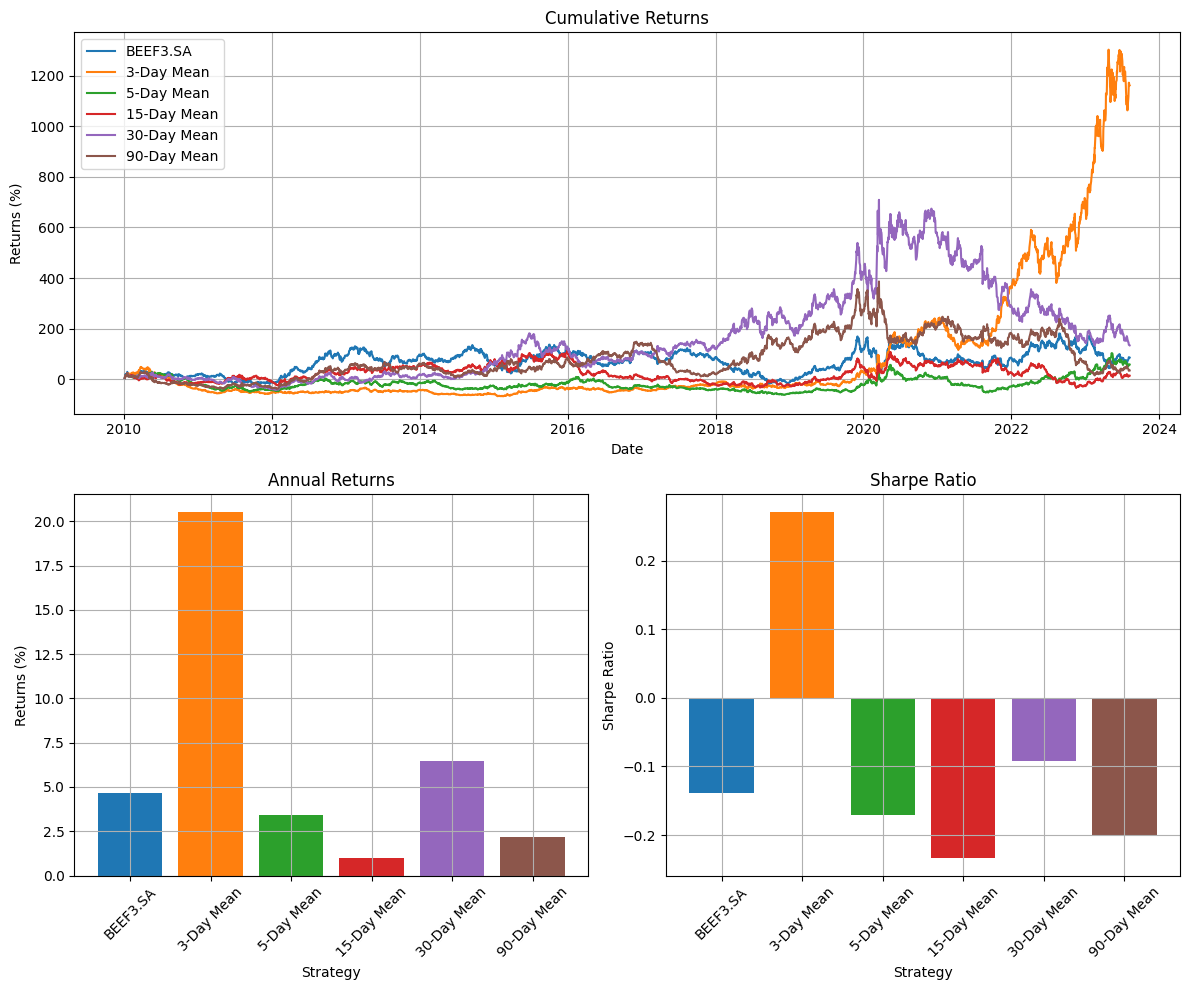

In [6]:
import matplotlib.gridspec as gridspec
periods = [3, 5, 15, 30, 90]
fig = plt.figure(figsize=(12, 10))
gs = fig.add_gridspec(4, 4)
ax0 = fig.add_subplot(gs[:2, :4])
ax1 = fig.add_subplot(gs[2:, :2])
ax2 = fig.add_subplot(gs[2:, 2:])
ax0.plot((np.exp(returns.cumsum()) - 1) * 100, label=ticker, linestyle='-')
perf_dict = {'tot_ret': {'buy_and_hold': (np.exp(returns.sum()) - 1)}}
perf_dict['ann_ret'] = {'buy_and_hold': b_ann}
perf_dict['sharpe'] = {'buy_and_hold': b_sharpe}
for p in periods:
    log_perf = TSMStrategy(returns, period=p, shorts=True)
    perf = np.exp(log_perf.cumsum())
    perf_dict['tot_ret'][p] = (perf[-1] - 1)
    ann = (perf[-1] ** (1/years) - 1)
    perf_dict['ann_ret'][p] = ann
    vol = log_perf.std() * np.sqrt(252)
    perf_dict['sharpe'][p] = (ann - rfr) / vol
    ax0.plot((perf - 1) * 100, label=f'{p}-Day Mean')

ax0.set_ylabel('Returns (%)')
ax0.set_xlabel('Date')
ax0.set_title('Cumulative Returns')
ax0.grid()
ax0.legend()
_ = [ax1.bar(i, v * 100) for i, v in enumerate(perf_dict['ann_ret'].values())]
ax1.set_xticks([i for i, k in enumerate(perf_dict['ann_ret'])])
ax1.set_xticklabels([f'{k}-Day Mean'
    if type(k) is int else ticker for
    k in perf_dict['ann_ret'].keys()],
    rotation=45)
ax1.grid()
ax1.set_ylabel('Returns (%)')
ax1.set_xlabel('Strategy')
ax1.set_title('Annual Returns')
_ = [ax2.bar(i, v) for i, v in enumerate(perf_dict['sharpe'].values())]
ax2.set_xticks([i for i, k in enumerate(perf_dict['sharpe'])])
ax2.set_xticklabels([f'{k}-Day Mean'
    if type(k) is int else ticker for
    k in perf_dict['sharpe'].keys()],
    rotation=45)
ax2.grid()
ax2.set_ylabel('Sharpe Ratio')
ax2.set_xlabel('Strategy')
ax2.set_title('Sharpe Ratio')
plt.tight_layout()
plt.show()

In [8]:
#Case Utilize os tickers e verifique os resultados :  ( entre 01.01.2012 - 01.01.2020 ) - Fora da Pandemia
 #['PETR4.SA', 'ITUB4.SA', 'VALE3.SA', 'BBDC4.SA','^BVSP','BRL=X']